# SOMETHING 

In [ ]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

In [ ]:
MU_TRUE = 3
SIGMA_TRUE = .5

N = 50
z = np.random.normal(loc=MU_TRUE, scale=SIGMA_TRUE, size=N)
error_z = np.random.rand(N) * .1
z_obs = z + error_z

fig, ax = plt.subplots(2,2)

ax[0,0].plot(z, linestyle='', marker='o', color='green')
ax[0,1].hist(z, orientation=u'horizontal')
ax[0,1].set_ylabel('$z$')
ax[0,1].set_xlabel('$dN/dz$')

ax[1,0].errorbar(np.linspace(0,N,N), z_obs, yerr=error_z, color='green', capsize=0, linestyle='', marker='o')
ax[1,1].hist(z_obs, orientation=u'horizontal', label='Observed')
ax[1,1].hist(z, orientation=u'horizontal', fill=False, histtype='step', label='True')
ax[1,1].legend(ncol=2)
ax[1,1].set_ylabel('$z$')
ax[1,1].set_xlabel('$dN/dz$')

# Est. param of ST. Line

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)
m_true = -1
b_true = 2

Text(0, 0.5, 'y')

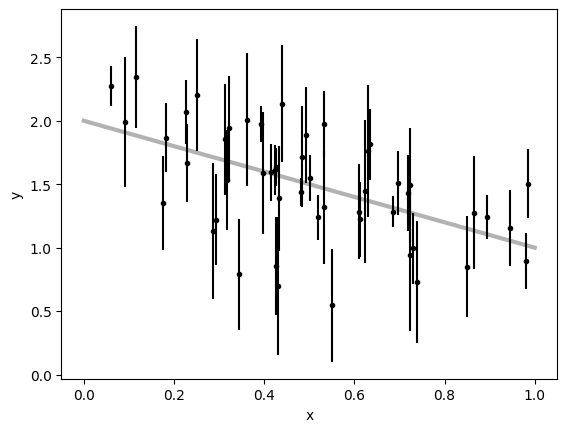

In [3]:
N = 50
x = np.sort(np.random.rand(N))

yerr = 0.1 + 0.5 * np.random.rand(N)

y = m_true * x + b_true
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 1, 50)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlabel("x")
plt.ylabel("y")

In [4]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

Maximum likelihood estimates:
m = -1.123
b = 2.105


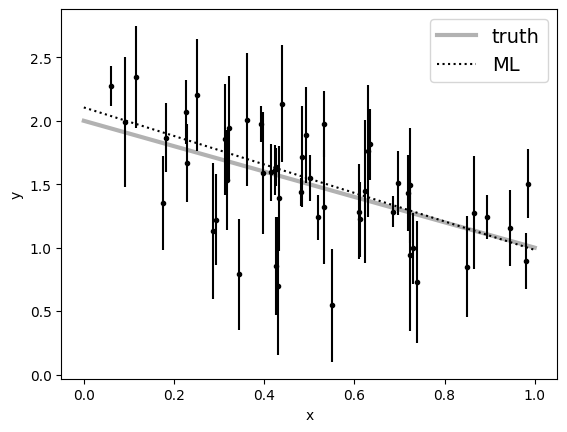

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");


In [6]:
def log_prior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

In [7]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [8]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:01<00:00, 2560.72it/s]


State([[-0.99236627  2.03347333]
 [-0.92506791  2.06490281]
 [-1.13154777  2.12340028]
 [-1.06481783  2.05710167]
 [-1.04594207  2.10186079]
 [-1.09321264  2.10676136]
 [-1.27470844  2.19723728]
 [-1.17217792  2.07251749]
 [-1.10317267  2.05263149]
 [-1.19499647  2.08746697]
 [-1.4004937   2.24181816]
 [-1.14579182  2.10810616]
 [-1.36852721  2.2209672 ]
 [-1.18806993  2.17321346]
 [-1.07383228  2.10763191]
 [-1.10659716  2.13576004]
 [-0.91192583  2.06037326]
 [-1.05929816  2.07971764]
 [-1.22714773  2.20507615]
 [-1.17334225  2.08182258]
 [-0.9537277   2.02628813]
 [-1.01678076  2.0228328 ]
 [-0.94891777  2.02734425]
 [-0.94608103  1.96653272]
 [-1.25227456  2.19087602]
 [-1.376758    2.24748205]
 [-1.07829319  2.1009845 ]
 [-1.41229939  2.22348168]
 [-1.30615793  2.22498286]
 [-1.37832543  2.21549709]
 [-1.20237246  2.03938433]
 [-1.32587316  2.2583294 ]], log_prob=[-17.19825966 -18.98323736 -16.93730001 -17.05532637 -17.45821576
 -16.98619874 -17.37901809 -18.15511524 -17.54185552 

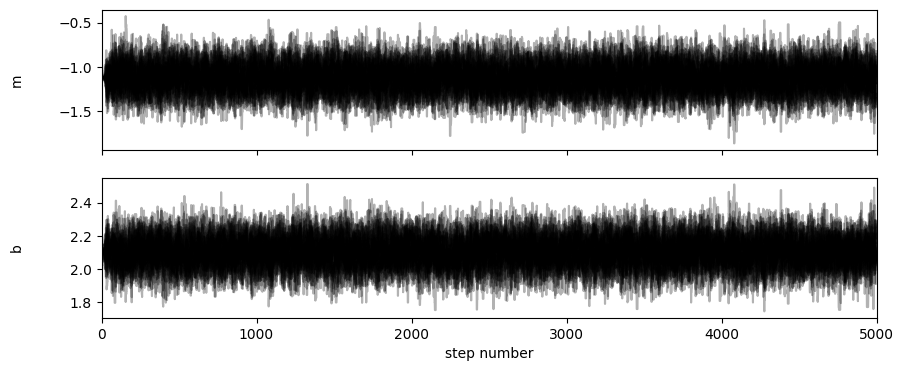

In [9]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [10]:
tau = sampler.get_autocorr_time()
print(tau)

[30.65267017 30.7001897 ]


In [11]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


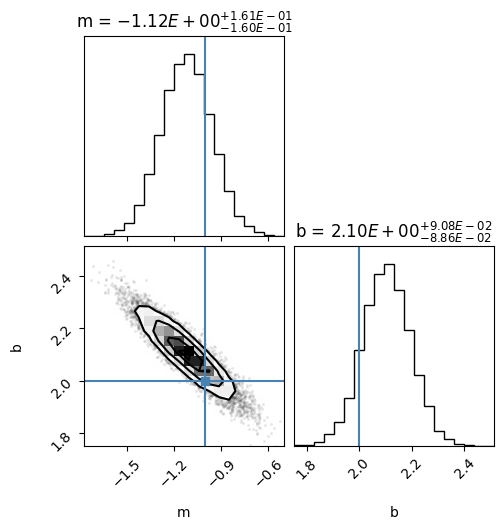

In [12]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# Est. param of a. Gaussian

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [14]:
np.random.seed(123)
mu_true = 5
sigma_true = .5

Text(0, 0.5, 'y')

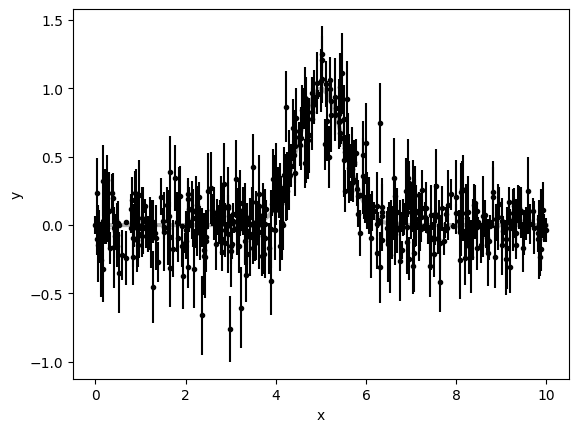

In [15]:
N = 500
x = np.sort(10 * np.random.rand(N))

yerr = 0.3 * np.random.rand(N)

y = np.exp(-(x-mu_true)**2 / sigma_true)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 100)
plt.plot(x0, np.exp(-(x0-mu_true)**2 / sigma_true), "k", alpha=0.3, lw=3)
plt.xlabel("x")
plt.ylabel("y")

In [16]:
def log_likelihood(theta, x, y, yerr):
    mu, sigma = theta
    model = np.exp(-(x-mu)**2 / sigma)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

In [17]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([mu_true, sigma_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(x, y, yerr))
mu_ml, sigma_ml = soln.x

print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_true))
print("sigma = {0:.3f}".format(sigma_ml))



Maximum likelihood estimates:
mu = 5.000
sigma = 0.498


In [18]:
def log_prior(theta):
    mu, sigma = theta
    if 0 < mu < 10 and 0 < sigma < 1.0:
        return 0.0
    return -np.inf

In [19]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [20]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:02<00:00, 1790.28it/s]


State([[5.00846293 0.49915091]
 [5.00780364 0.49488154]
 [5.00328869 0.49916502]
 [5.00013063 0.49747434]
 [4.99808123 0.49692116]
 [5.00046893 0.4987595 ]
 [5.00298759 0.50180034]
 [4.99750954 0.49584148]
 [5.00604133 0.49521145]
 [4.99598957 0.49468406]
 [5.00639407 0.49321658]
 [5.00977055 0.49362969]
 [5.00370753 0.49900032]
 [5.00174873 0.49777068]
 [5.00465067 0.49838056]
 [5.00531146 0.50055952]
 [5.00554109 0.50154868]
 [5.00384275 0.49709441]
 [5.00266987 0.50336995]
 [5.00271094 0.49664905]
 [4.99781034 0.50071394]
 [5.00651346 0.49531686]
 [5.00519854 0.49407162]
 [4.99782433 0.4926984 ]
 [5.0019249  0.49868199]
 [5.0027462  0.49884729]
 [5.00572085 0.49786657]
 [4.99918585 0.49401505]
 [5.00453373 0.49710794]
 [5.00734146 0.49450724]
 [5.00484735 0.48903495]
 [5.00692495 0.49907439]], log_prob=[403.73515962 403.81927141 404.8264327  404.46701886 403.71577142
 404.49542091 404.28944214 403.37849052 404.41396209 402.37623761
 403.86666547 402.62608188 404.84056185 404.8004004

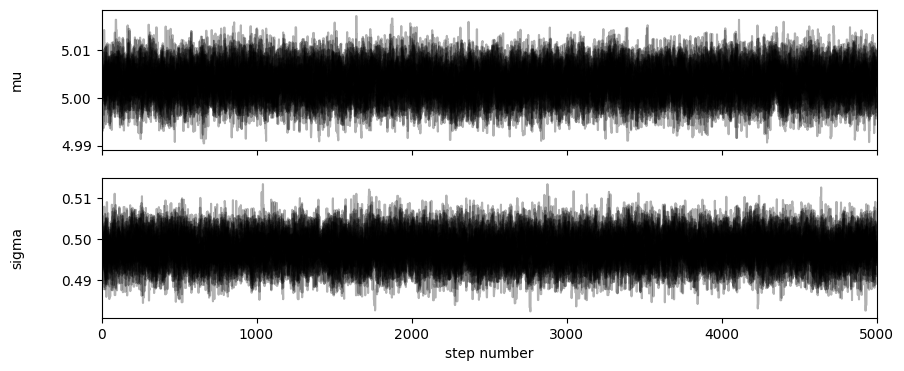

In [21]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [22]:
tau = sampler.get_autocorr_time()
print(tau)

[28.56568    30.99922033]


In [23]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


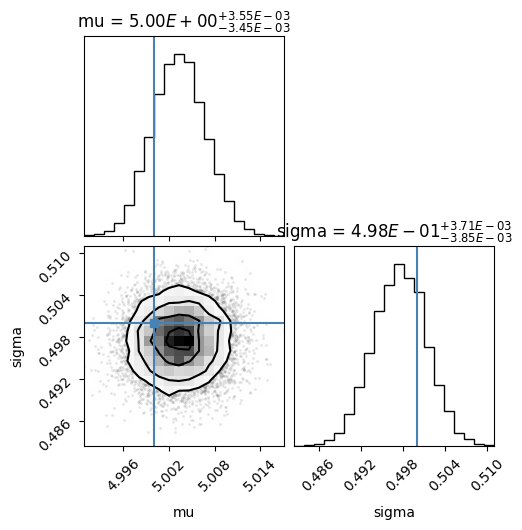

In [24]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[mu_true, sigma_true], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# Bimodal distribution

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

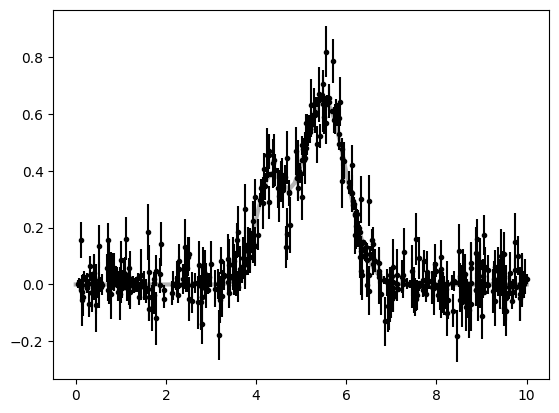

In [26]:
SEEDS = 500
A = .35
MU_A = 4.3
MU_B = 5.5
SIGMA_A = .2
SIGMA_B = .5

z = np.sort(10 * np.random.rand(SEEDS))

ERROR_IN_PARAM = 0.1 * np.random.rand(SEEDS)

y = A * np.exp(-(z-MU_A)**2 / SIGMA_A) + (1-A) * np.exp(-(z-MU_B)**2 / SIGMA_B)
y += ERROR_IN_PARAM * np.random.randn(SEEDS)

# TESTING DISTRIBUTIONS

plt.errorbar(z, y, yerr=ERROR_IN_PARAM, fmt=".k", capsize=0)
z0 = np.linspace(0, 10, 100)
plt.plot(z0, A * np.exp(-(z0-MU_A)**2 / SIGMA_A) + (1-A) * np.exp(-(z0-MU_B)**2 / SIGMA_B), "k", alpha=0.3, lw=3)

In [27]:
def log_likelihood(theta, z, y, yerr):
    a, mu_a, sigma_a, mu_b, sigma_b  = theta
    model = a * np.exp(-(z-mu_a)**2 / sigma_a) + (1-a) * np.exp(-(z-mu_b)**2 / sigma_b)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

In [28]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([A, MU_A, SIGMA_A, MU_B, SIGMA_B]) + 0.1 * np.random.randn(5)
soln = minimize(nll, initial, args=(z, y, ERROR_IN_PARAM))
a_ml, mu_a_ml, sigma_a_ml, mu_b_ml, sigma_b_ml = soln.x

print("Maximum likelihood estimates:")
print("A= {0:.3f}".format(a_ml))
print("MU_A = {0:.3f}".format(mu_a_ml))
print("SIGMA_A = {0:.3f}".format(sigma_b_ml))
print("MU_B = {0:.3f}".format(mu_b_ml))
print("SIGMA_B = {0:.3f}".format(sigma_b_ml))


Maximum likelihood estimates:
A= 0.349
MU_A = 4.292
SIGMA_A = 0.504
MU_B = 5.500
SIGMA_B = 0.504


/tmp/ipykernel_31956/3106713249.py:5: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))
/tmp/ipykernel_31956/3106713249.py:5: RuntimeWarning: overflow encountered in true_divide
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_31956/3106713249.py:5: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))
/tmp/ipykernel_31956/3106713249.py:5: RuntimeWarning: overflow encountered in true_divide
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))


In [29]:
def log_prior(theta):
    a, mu_a, sigma_a, mu_b, sigma_b = theta
    if 0 < a < 1 and 0 < mu_a < 5 and 0 < sigma_a < 1 and 2 < mu_b < 7 and 0 < sigma_b < 1:
        return 0.0
    return -np.inf

In [30]:
def log_probability(theta, z, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, y, yerr)


In [31]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z, y, ERROR_IN_PARAM)
)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:05<00:00, 866.66it/s]


State([[0.35045656 4.29543556 0.20268642 5.50155881 0.5012968 ]
 [0.35064078 4.28481967 0.19100962 5.49730362 0.50819779]
 [0.34700851 4.30351952 0.21309568 5.50619103 0.49516309]
 [0.34912835 4.30152151 0.20162114 5.50263996 0.50137281]
 [0.3499224  4.29944013 0.2039344  5.50265106 0.50241232]
 [0.34736177 4.30832778 0.20200504 5.50370065 0.49898844]
 [0.34908505 4.30730453 0.1990289  5.50329338 0.50082862]
 [0.35014263 4.28118052 0.18302694 5.49377348 0.51098361]
 [0.34953521 4.2904464  0.19195949 5.49900699 0.50831888]
 [0.35083266 4.29040959 0.19043729 5.49723247 0.50965002]
 [0.34942631 4.29713079 0.20253479 5.50020177 0.50101475]
 [0.34915112 4.29173158 0.19669101 5.49978318 0.50519556]
 [0.3488661  4.28298502 0.1938819  5.49858154 0.50758687]
 [0.34794448 4.30696965 0.20063249 5.50373015 0.49861738]
 [0.34890782 4.28674203 0.19214758 5.49871586 0.50702581]
 [0.34945721 4.29772518 0.20102122 5.50260226 0.50388773]
 [0.3483029  4.29514965 0.19989578 5.50177564 0.50071164]
 [0.3504

Text(0.5, 0, 'step number')

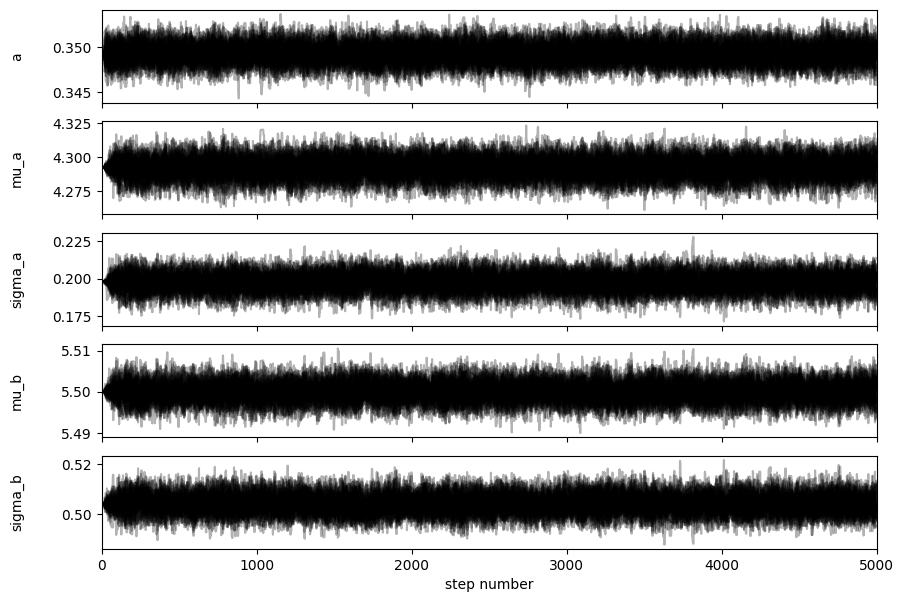

In [32]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "mu_a", "sigma_a", "mu_b", "sigma_b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


In [33]:
tau = sampler.get_autocorr_time()
print(tau)

[49.43780444 54.30816119 56.93930674 57.93607147 55.53127938]


In [34]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 5)


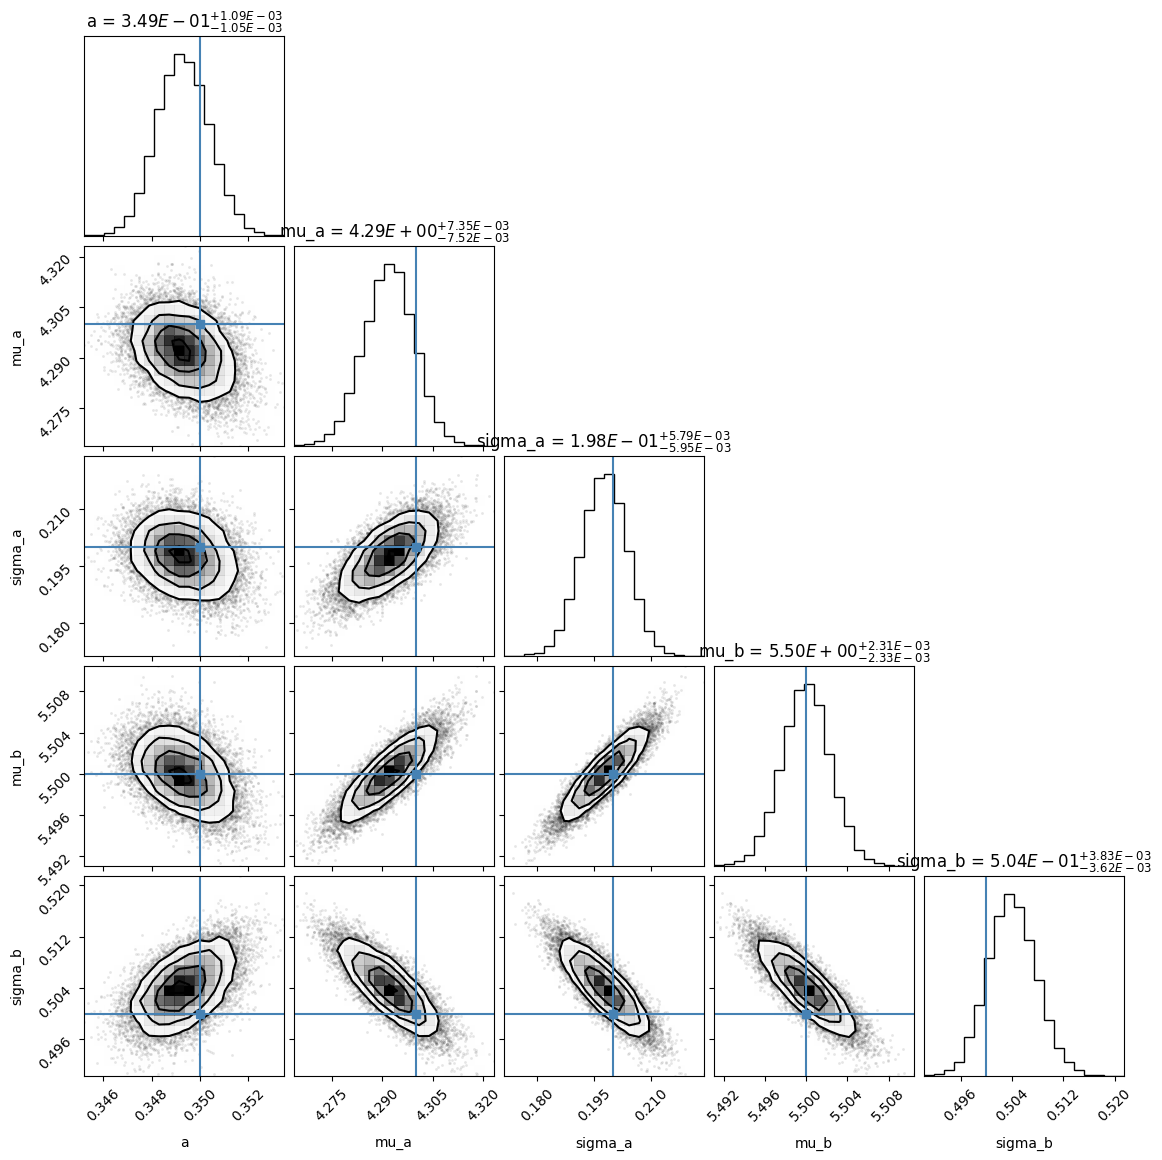

In [35]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[A, MU_A, SIGMA_A, MU_B, SIGMA_B], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# HM model

In [36]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

In [37]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean,
    scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

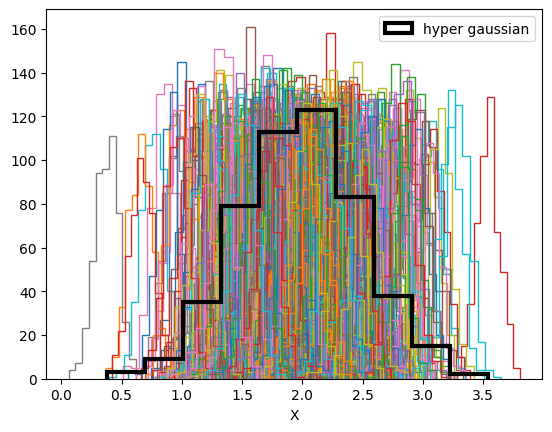

In [38]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 2.0 # hyperparameter
true_parent_scale = .5 # hyperparameter
true_child_scale = 0.1

N_obs = 500
size_child = 500

# Hypothesis for parent gaussian 
hyper_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

true_gaussian = np.random.normal(loc=hyper_gaussian[:, np.newaxis], scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(true_gaussian[i], fill=False, histtype='step')
plt.hist(hyper_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian')
plt.xlabel("X")
plt.legend()

In [39]:
def hierarchical_model(params):
    """
    Generate child data from the hierarchical model in steps 
    of first generating a parent data which then will be used 
    to generate child data.
    """
    parent_mean, parent_scale = params
    parent_data = generate_data(parent_mean, parent_scale, size=N_obs)
    child_data = np.random.normal(loc=parent_data[:, np.newaxis], scale=true_child_scale, size=(N_obs, size_child))
    return child_data

In [40]:
def log_likelihood(params):
    # parent_mean, parent_scale = params 
    # above not required here ?
    model_data = hierarchical_model(params)
    residuals = true_gaussian - model_data
    
    # Q : is the scaling correct here ?
    
    chi_square = np.sum(residuals**2 / (2 * true_child_scale**2) + np.log(2 * np.pi * true_child_scale**2))
    #chi_square = np.sum(residuals**2)
    return - 0.5 * chi_square

def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        
        return 0.0
    
    return -np.inf

def log_posterior(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [41]:
# Initial parameter values (guess values use of ML ?)
initial_params = [1.0, 0.1]

# Number of walkers (chains) and number of steps
n_walkers = 20
n_steps = 5000

initial_positions = [initial_params + 1e-2 * np.random.randn(2) for _ in range(n_walkers)]

ndim = len(initial_params)
sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior)
sampler.run_mcmc(initial_positions, n_steps, progress=True)

100%|██████████| 5000/5000 [07:59<00:00, 10.43it/s]


State([[1.9715646  0.05607668]
 [1.96999022 0.03963439]
 [1.99681502 0.03683486]
 [1.96487614 0.02822309]
 [1.97894177 0.04676232]
 [1.98323188 0.06061214]
 [1.93565563 0.06131036]
 [1.96499114 0.04782883]
 [1.99085729 0.0337632 ]
 [1.94931122 0.04625389]
 [1.95710452 0.05003545]
 [1.95171806 0.06630538]
 [1.9754236  0.04625347]
 [1.98537343 0.07805494]
 [1.93903533 0.05197033]
 [1.95403919 0.03660285]
 [1.98253955 0.04567469]
 [1.98701223 0.04752635]
 [1.99503311 0.04882208]
 [1.97211657 0.04749776]], log_prob=[-1272961.88977092 -1276893.23537294 -1276620.03787199 -1274958.91816964
 -1276400.50629004 -1261394.23797435 -1277295.52459022 -1265740.10412048
 -1277572.74908257 -1281122.65754055 -1267178.68189458 -1270604.71198759
 -1261846.57260051 -1270087.66242809 -1276680.61838859 -1273994.59290165
 -1271781.01694388 -1269351.86847314 -1273032.51119207 -1266668.8198909 ], blobs=None, random_state=('MT19937', array([1875417383, 1641852768, 2387214326, 2572440329, 3347222460,
        6627

Text(0.5, 0, 'step number')

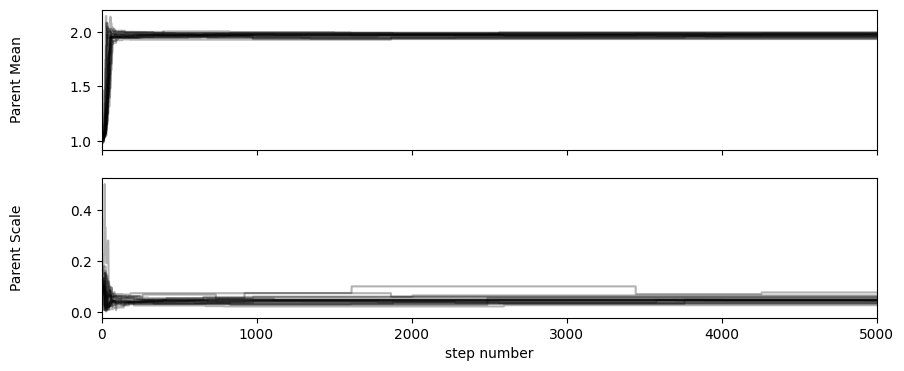

In [42]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["Parent Mean", "Parent Scale"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [44]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 47.11168761 278.2574803 ]

In [46]:
flat_samples = sampler.get_chain(discard=200, thin=10, flat=True) 
print(flat_samples.shape)

(9600, 2)


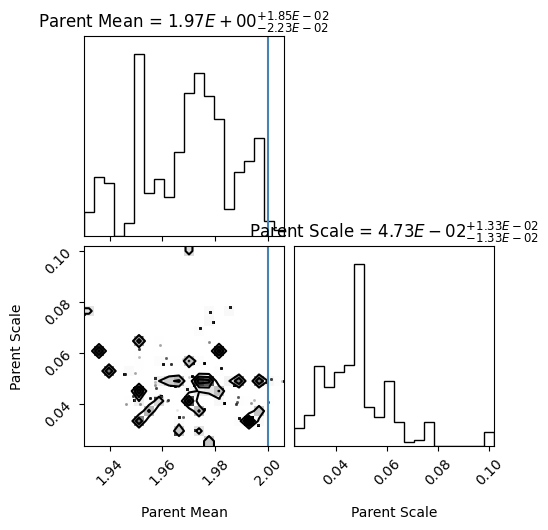

In [47]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# HM but inv

## test-1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
np.random.seed(123)
mu_true = 2
sigma_true = .5
N = 100

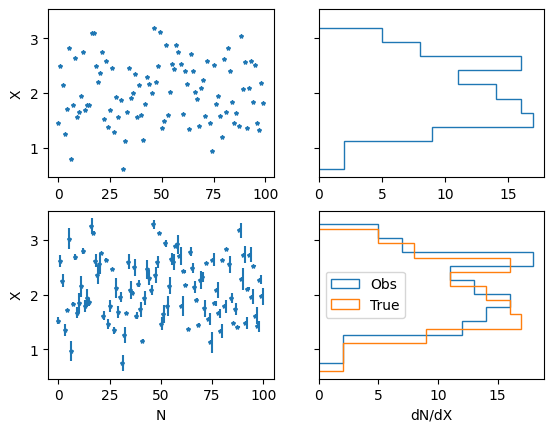

In [3]:
X = sigma_true * np.random.randn(N) + mu_true

fig, ax = plt.subplots(2,2, sharey=True)

ax[0,0].plot(X, linestyle='', marker='*', markersize=3)
ax[0,1].hist(X, orientation=u'horizontal', fill=False, histtype='step')
ax[0,0].set_ylabel('X')
X_err = 0.2 * np.random.random(N)
X_obs = X + X_err

ax[1,0].errorbar(np.linspace(0,N,N), X_obs, yerr=X_err, fmt="none", capsize=0)
ax[1,0].plot(X_obs, linestyle='', marker='*', markersize=3)
ax[1,1].hist(X_obs, orientation=u'horizontal', fill=False, histtype='step',label='Obs')
ax[1,1].hist(X, orientation=u'horizontal', fill=False, histtype='step', label='True')
ax[1,0].set_ylabel('X')
ax[1,0].set_xlabel('N')
ax[1,1].set_xlabel('dN/dX')
plt.legend()

In [4]:
def log_likelihood(theta, x_i, x_err):
    """
    theta : parameters
    x_i : observed values of X
    x_err : scaling of x_i's
    """
    mu, sigma = theta
    # new x_i's are generated from the hyper params
    model = sigma * np.random.randn(N) + mu
    sigma = x_err
    return -0.5 * np.sum((x_i - model) ** 2 / sigma**2 + np.log(2*np.pi*sigma**2))

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([mu_true, sigma_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(X_obs, X_err))
mu_ml, sigma_ml = soln.x

print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 2.050
sigma = 0.486


In [6]:
def log_prior(theta):
    """
    theta : parameters
    """
    mu, sigma = theta # hyperpriors
    if -5 < mu < 5 and 0 < sigma < 1.0:
        return 0.0
    return -np.inf

In [7]:
def log_posterior(theta, x_i, x_err):
    """
    theta : parameters
    x_i : observed values of X
    x_err : scaling of x_i's
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x_i, x_err)

In [8]:
import emcee

pos = soln.x + 1e-1 * np.random.randn(5, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=[X_obs, X_err]
)
sampler.run_mcmc(pos, 20000, progress=True)

100%|██████████| 20000/20000 [00:03<00:00, 5889.10it/s]


State([[2.20973401 0.56509991]
 [2.2750706  0.44447249]
 [2.29988028 0.50116141]
 [2.2288229  0.49205508]
 [1.98955465 0.62235269]], log_prob=[-16749.94215171 -15512.72496184 -15872.72066633 -14831.51435557
 -18331.04491065], blobs=None, random_state=('MT19937', array([1311818410, 2539395702, 3347530291, 1034442367, 2987172929,
       1669981128,  216566154,  260349724, 3979318839, 4105851067,
       2568347777, 1284884550,  309435818, 2757879550, 1952652312,
       2385907374,  284598398, 1036997140,   68918056, 1667452013,
       4093307207, 3982728415, 2284470690, 2596772137, 4115258698,
       3302369440,  446725385, 1155185357, 3281526613,  109114102,
        944913089, 2212653403, 3883278088,  316774372, 3910450294,
       1127191725, 3412633996, 3182310360, 3798057314, 1954153664,
       1417288344, 2606613596, 3437102313, 3364170999, 3465658566,
       4246835269,  515999065, 2393457968, 4051986875, 1214539430,
        132642375, 1435207270,  686644272, 3235503781,  461801849,


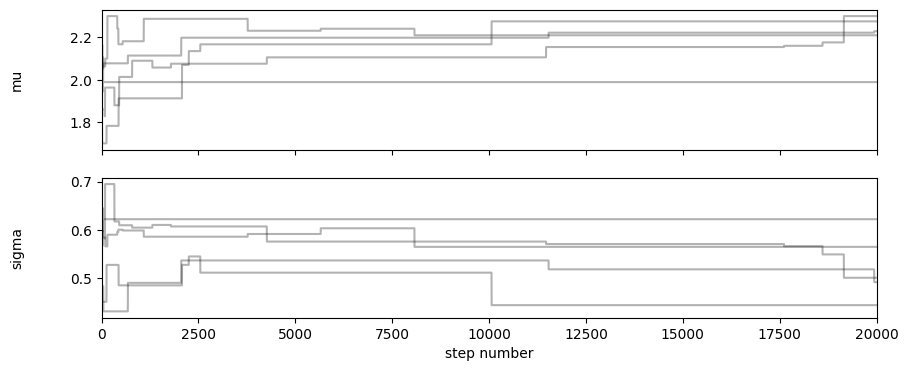

In [9]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [17]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [904.75261281 932.4030044 ]

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(3300, 2)


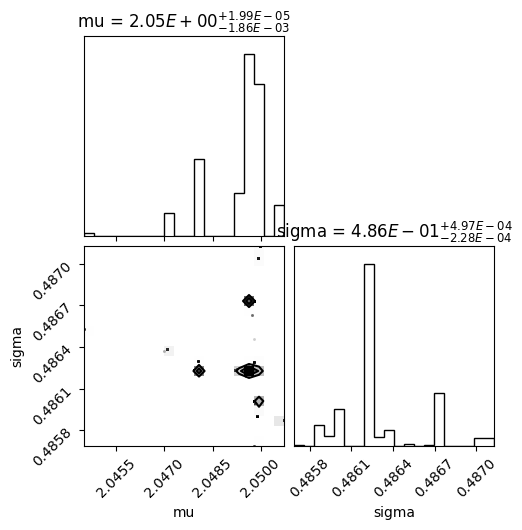

In [14]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[mu_true, sigma_true], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

## test-2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [3]:
np.random.seed(123)
mu_true = 5
sigma_true = 1
N_obs = 100

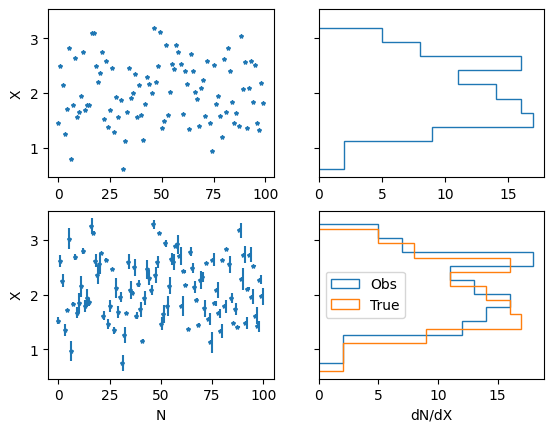

In [ ]:
X = sigma_true * np.random.randn(N) + mu_true

fig, ax = plt.subplots(2,2, sharey=True)

ax[0,0].plot(X, linestyle='', marker='*', markersize=3)
ax[0,1].hist(X, orientation=u'horizontal', fill=False, histtype='step')
ax[0,0].set_ylabel('X')
X_err = 0.2 * np.random.random(N)
X_obs = X + X_err

ax[1,0].errorbar(np.linspace(0,N,N), X_obs, yerr=X_err, fmt="none", capsize=0)
ax[1,0].plot(X_obs, linestyle='', marker='*', markersize=3)
ax[1,1].hist(X_obs, orientation=u'horizontal', fill=False, histtype='step',label='Obs')
ax[1,1].hist(X, orientation=u'horizontal', fill=False, histtype='step', label='True')
ax[1,0].set_ylabel('X')
ax[1,0].set_xlabel('N')
ax[1,1].set_xlabel('dN/dX')
plt.legend()

In [ ]:
def log_likelihood(theta, x_i, x_err):
    """
    theta : parameters
    x_i : observed values of X
    x_err : scaling of x_i's
    """
    mu, sigma = theta
    # new x_i's are generated from the hyper params
    model = sigma * np.random.randn(N) + mu
    sigma = x_err
    return -0.5 * np.sum((x_i - model) ** 2 / sigma**2 + np.log(2*np.pi*sigma**2))

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([mu_true, sigma_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(X_obs, X_err))
mu_ml, sigma_ml = soln.x

print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 2.050
sigma = 0.486


In [ ]:
def log_prior(theta):
    """
    theta : parameters
    """
    mu, sigma = theta # hyperpriors
    if -5 < mu < 5 and 0 < sigma < 1.0:
        return 0.0
    return -np.inf

In [ ]:
def log_posterior(theta, x_i, x_err):
    """
    theta : parameters
    x_i : observed values of X
    x_err : scaling of x_i's
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x_i, x_err)

In [ ]:
import emcee

pos = soln.x + 1e-1 * np.random.randn(5, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=[X_obs, X_err]
)
sampler.run_mcmc(pos, 20000, progress=True)

100%|██████████| 20000/20000 [00:03<00:00, 5889.10it/s]


State([[2.20973401 0.56509991]
 [2.2750706  0.44447249]
 [2.29988028 0.50116141]
 [2.2288229  0.49205508]
 [1.98955465 0.62235269]], log_prob=[-16749.94215171 -15512.72496184 -15872.72066633 -14831.51435557
 -18331.04491065], blobs=None, random_state=('MT19937', array([1311818410, 2539395702, 3347530291, 1034442367, 2987172929,
       1669981128,  216566154,  260349724, 3979318839, 4105851067,
       2568347777, 1284884550,  309435818, 2757879550, 1952652312,
       2385907374,  284598398, 1036997140,   68918056, 1667452013,
       4093307207, 3982728415, 2284470690, 2596772137, 4115258698,
       3302369440,  446725385, 1155185357, 3281526613,  109114102,
        944913089, 2212653403, 3883278088,  316774372, 3910450294,
       1127191725, 3412633996, 3182310360, 3798057314, 1954153664,
       1417288344, 2606613596, 3437102313, 3364170999, 3465658566,
       4246835269,  515999065, 2393457968, 4051986875, 1214539430,
        132642375, 1435207270,  686644272, 3235503781,  461801849,


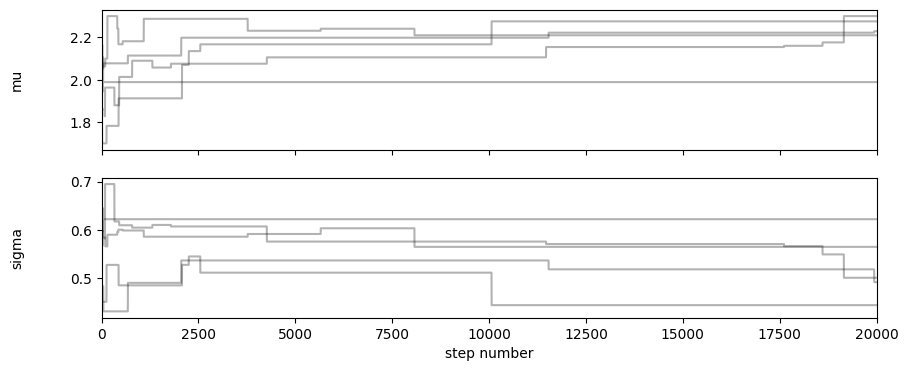

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(3300, 2)


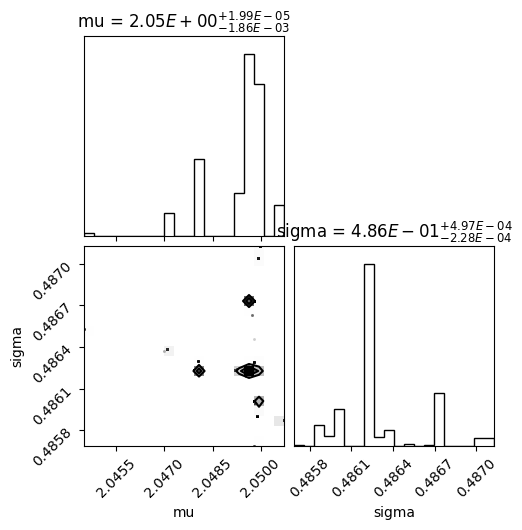

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[mu_true, sigma_true], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# some code

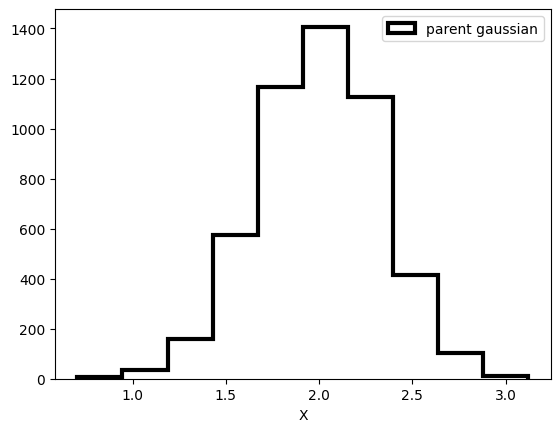

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

true_mean_parent = 2
true_scale_parent = 0.32
true_scale_child = 0.01
N_obs, size_child = 5000, 5

def gen_child_data(parent_data):
    return np.random.normal(loc=parent_data[:, np.newaxis], scale=true_scale_child, size=(N_obs, size_child))

def gen_parent_data(mu, sigma):
    return np.random.normal(loc=mu, scale=sigma, size=N_obs)

parent_data = gen_parent_data(true_mean_parent, true_scale_parent)
child_data = gen_child_data(parent_data)

#for i in range(N_obs):
#    plt.hist(child_data[i], fill=False, histtype='step')
plt.hist(parent_data, fill=False, histtype='step', color='black',linewidth=3, label='parent gaussian')
plt.xlabel("X")
plt.legend()

(array([   5.,   33.,  158.,  573., 1168., 1407., 1127.,  416.,  103.,
          10.]),
 array([0.70366004, 0.94546944, 1.18727883, 1.42908823, 1.67089763,
        1.91270702, 2.15451642, 2.39632581, 2.63813521, 2.87994461,
        3.121754  ]),
 [<matplotlib.patches.Polygon at 0x7fda186ec9d0>])

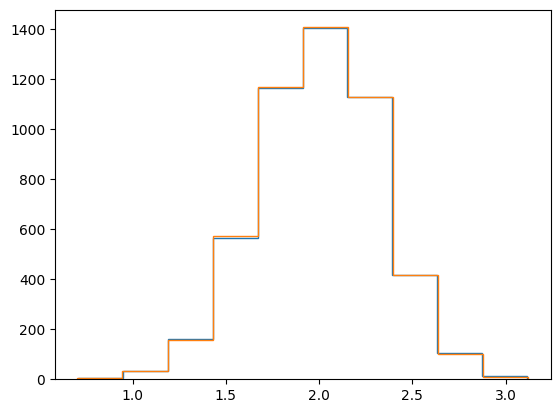

In [2]:
plt.hist(child_data.mean(axis=1),fill=False, histtype='step')
plt.hist(parent_data, fill=False, histtype='step')

In [3]:
def log_liklihood(param):
    parent_mu, parent_sigma = param # mu is fixed and so is sigma
    #model = gen_child_data(parent_data=gen_parent_data(parent_mu, parent_sigma))
    model = parent_sigma * np.random.randn(N_obs) + parent_mu
    return -0.5 * np.sum(np.log(2 * np.pi * true_scale_child**2) + (child_data.mean(axis=1) - model)**2 / true_scale_child**2)

def log_prior(param):
    parent_mu, parent_sigma = param
    if (true_mean_parent - 5 < parent_mu < true_mean_parent + 5 and 
        0.0 < parent_sigma < 1.0):
        return 0.0
    return -np.inf

def log_probability(param):
    lp = log_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_liklihood(param)

In [4]:
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_liklihood(*args)
initial = np.array([true_mean_parent, true_scale_parent]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
parent_mu_ML, parent_sigma_ML = soln.x

print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(parent_mu_ML))
print("sigma = {0:.3f}".format(parent_sigma_ML))

Maximum likelihood estimates:
mu = 2.050
sigma = 0.306


In [14]:
import emcee

pos = soln.x + 1e-1 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

#from multiprocessing import Pool

#with Pool() as pool:
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability#, pool=pool
    )
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:06<00:00, 736.44it/s]


State([[2.02012413 0.04714025]
 [1.98500273 0.0459215 ]
 [2.00987342 0.03228067]
 [1.99289272 0.05792051]
 [1.99832832 0.03176788]
 [2.02133999 0.03812692]
 [2.01992153 0.05375256]
 [2.00763319 0.02676397]
 [2.01667006 0.03934323]
 [2.00181363 0.02883449]
 [2.01121414 0.05506178]
 [2.01444649 0.06865805]
 [2.02442231 0.05151661]
 [2.00154726 0.02891744]
 [2.01633086 0.03220115]
 [2.00709291 0.0375946 ]
 [2.00523764 0.03925498]
 [1.98792314 0.04749197]
 [2.00593124 0.05062602]
 [2.002825   0.04276521]
 [2.00614187 0.03843682]
 [2.01906294 0.02921569]
 [2.00228552 0.02899309]
 [2.01858567 0.03662083]
 [1.99943247 0.03135211]
 [2.02038843 0.04803005]
 [2.01178041 0.0294457 ]
 [2.01167691 0.02808431]
 [2.01186248 0.04633343]
 [2.0261301  0.04776523]
 [2.01929901 0.02749709]
 [2.01171748 0.04566739]
 [2.02087578 0.05477399]
 [2.02218907 0.04206159]
 [2.01109941 0.04502713]
 [2.00927187 0.0385238 ]
 [2.00802092 0.03185099]
 [2.01468919 0.03427636]
 [2.0159276  0.04743103]
 [2.01979805 0.0582

Text(0.5, 0, 'step number')

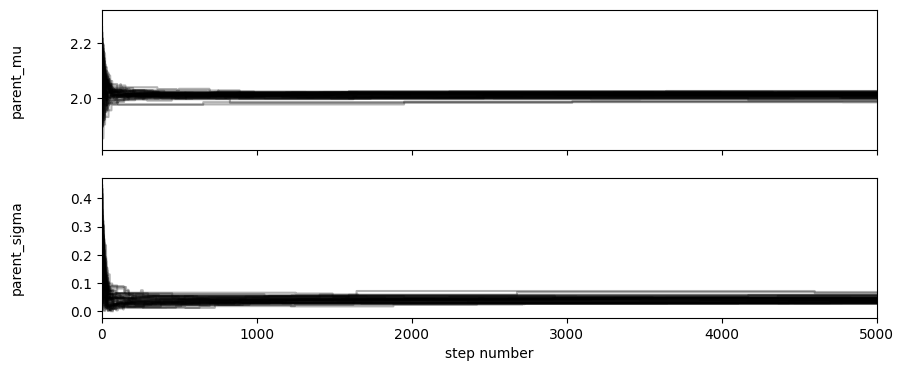

In [15]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["parent_mu", "parent_sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


In [8]:
flat_samples = sampler.get_chain(discard=10, thin=15, flat=True)
print(flat_samples.shape)

(33300, 2)


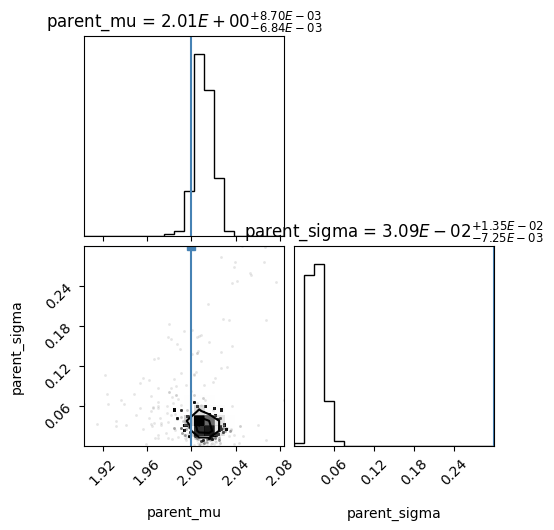

In [9]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_mean_parent, true_scale_parent], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# CHECKING SOME CODE 

100%|██████████| 1000/1000 [00:00<00:00, 1712.01it/s]


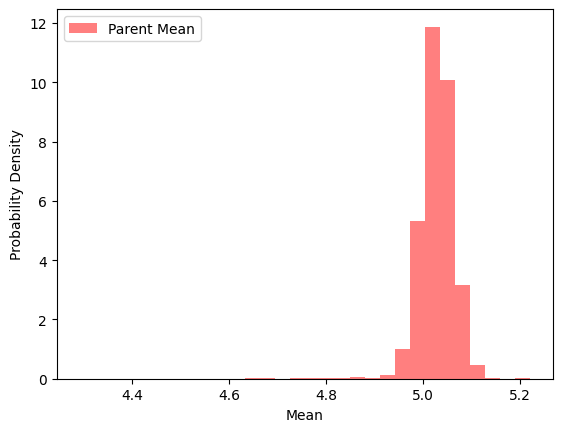

True Parent Mean: 5
Inferred Parent Mean: 5.027455384963378


In [11]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to generate data from parent and child distributions
def generate_data(parent_mean, child_size, child_std):
    parent_data = np.random.normal(parent_mean, 1, size=1000)
    child_data = np.random.normal(parent_data, child_std, size=(child_size, len(parent_data)))
    return parent_data, child_data

# Log-likelihood function for child distributions
def ln_likelihood_child(theta, data):
    child_means, child_std = theta
    return -0.5 * np.sum(np.log(2 * np.pi * child_std**2) + ((data - child_means)**2) / child_std**2)

# Log-likelihood function for parent distribution
def ln_likelihood_parent(theta, data):
    parent_mean, parent_std = theta
    return -0.5 * np.sum(np.log(2 * np.pi * parent_std**2) + ((data - parent_mean)**2) / parent_std**2)

# Log-prior for both parent and child distributions
def ln_prior(theta):
    mean, std = theta
    if 0 < std < 10:
        return 0.0
    return -np.inf

# Log-posterior function for child distributions
def ln_posterior_child(theta, data):
    ln_prior_value = ln_prior(theta)
    if np.isinf(ln_prior_value):
        return ln_prior_value
    return ln_prior_value + ln_likelihood_child(theta, data)

# Log-posterior function for parent distribution
def ln_posterior_parent(theta, data):
    ln_prior_value = ln_prior(theta)
    if np.isinf(ln_prior_value):
        return ln_prior_value
    return ln_prior_value + ln_likelihood_parent(theta, data)

# Function to run the MCMC for child distributions
def run_mcmc_child(data):
    ndim = 2  # Number of parameters (mean and std)
    nwalkers = 50  # Number of walkers
    nsteps = 1000  # Number of steps

    # Initial positions for the walkers
    initial_positions = np.random.rand(nwalkers, ndim)

    # Run the MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_child, args=[data])
    sampler.run_mcmc(initial_positions, nsteps, progress=True)

    # Get the samples
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    return samples.mean(axis=0)

# Function to run the MCMC for the parent distribution
def run_mcmc_parent(data):
    ndim = 2  # Number of parameters (mean and std)
    nwalkers = 50  # Number of walkers
    nsteps = 1000  # Number of steps

    # Initial positions for the walkers
    initial_positions = np.random.rand(nwalkers, ndim)

    # Run the MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_parent, args=[data])
    sampler.run_mcmc(initial_positions, nsteps, progress=True)

    # Get the samples
    samples = sampler.get_chain()

    # Plot the results
    return samples.mean(axis=0)

# Generate data from parent and child distributions
parent_mean_true = 5
child_size = 500
child_std_true = 2
parent_data_true, child_data_true = generate_data(parent_mean_true, child_size, child_std_true)

# Run MCMC for child distributions
child_mean_inferred = run_mcmc_child(child_data_true)

# Run MCMC for parent distribution using the inferred child means
parent_data_inferred, _ = generate_data(child_mean_inferred[0], child_size, child_std_true)
parent_mean_inferred = run_mcmc_parent(parent_data_inferred)

print("True Parent Mean:", parent_mean_true)
print("Inferred Parent Mean:", parent_mean_inferred[0])
